In [1]:
from irbasis_util.four_point_ph_view import *
from irbasis_util.internal import *
from irbasis_util.regression import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#padding on the y axis between label and axis
plt.rcParams['ytick.major.pad']='10'

dpi_out = 400
fig_width = 3.39
golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
fig_height = fig_width*golden_mean # height in inches
MAX_HEIGHT_INCHES = 8.0
if fig_height > MAX_HEIGHT_INCHES:
    print("WARNING: fig_height too large:" + fig_height + 
          "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
    fig_height = MAX_HEIGHT_INCHES
#fig, ax = plt.subplots(figsize = (fig_width, fig_height), frameon=True)
small_tick_size = 8
small_label_size = 8

In [3]:
# Implementation of Rohringer et al. () 2012)
def _delta(i, j):
    if i==j:
        return 1
    else:
        return 0

def _F_ph(U, beta, n, np, m):
    nu = (2 * n + 1) * numpy.pi / beta
    nu_p = (2 * np + 1) * numpy.pi / beta
    omega = 2 * m * numpy.pi / beta
    r1 = nu + omega
    r2 = nu_p + omega
    tmp = 1. / (nu * r1 * r2 * nu_p)
    Fuu = (-0.25 * beta * (U**2) * (_delta(n,np) - _delta(m,0)) *
               (1 + 0.25 * (U / nu)**2) * (1 + 0.25 * (U / r2)**2))
    t1 = 0.125 * (U**3) * (nu**2 + r1**2 + r2**2 + nu_p**2) * tmp
    t2 = (3.0 / 16.0) * (U**5) * tmp
    t3 = (beta * 0.25 * (U**2) *
              (1 / (1 + numpy.exp(0.5 * beta * U)))
              * (2 * _delta(nu, -nu_p - m) + _delta(m, 0)) *
              (1 + 0.25 * (U / r1)**2) * (1 + 0.25 * (U / r2)**2))
    t4 = (-beta * 0.25 * (U**2) *
              (1 / (1 + numpy.exp(-0.5 * beta * U)))
              * (2 * _delta(nu, nu_p) + _delta(m, 0)) *
              (1 + 0.25 * (U / nu)**2) * (1 + 0.25 * (U / r2)**2))
    Fud = -U + t1 + t2 + t3 + t4
    return Fuu, Fud

def _G2_conn_ph(U, beta, n, np, m):
    Fuu, Fud = _F_ph(U, beta, n, np, m)
    nu = (2 * n + 1) * numpy.pi / beta
    nu_p = (2 * np + 1) * numpy.pi / beta
    omega = 2 * m * numpy.pi / beta
    hU = 0.5 * U
    leggs_1 = nu * (nu + omega) * nu_p * (nu_p + omega)
    leggs_2 = ((hU**2 + nu**2) * (hU**2 + nu_p**2) *
                   (hU**2 + (nu + omega)**2) * (hU**2 + (nu_p + omega)**2))
    leggs = leggs_1 / leggs_2
    return (leggs * Fuu + leggs * Fud)

In [ ]:
def elbow_method(alphas, squared_errors):
    """
    
    Parameters
    ----------
    alphas    regularization parameters in ascending order
    squared_errors  corresponding squared_errors

    Returns index of optimal value of alpha in alphas
    -------

    """
    x = numpy.log(alphas)
    y = numpy.log(squared_errors)
    
    a = (y[-1] - y[0])/(x[-1] - x[0])
    y -= a * (x - x[0]) + y[0]
    
    r = numpy.argmin(y)
    if isinstance(r, numpy.int64):
        return r
    else:
        return r[0]

    
# Regression with multiple values of alpha
def ridge_complex_alphas(A, y, alphas, preconds):
    """
    
    Parameters
    ----------
    A
    y
    alphas  regularization parameters
    preconds list of preconditioners
    

    Returns
    -------

    """
    coeffs_alpha = []
    squared_errors_alpha = []
    for i, alpha in enumerate(alphas):
        print("alpha = ", alpha)
        coeffs = ridge_complex(A, y, alpha, solver='lsqr', precond=preconds[i], verbose=1)
        #coeffs = ridge_complex(A, y, alpha)
        coeffs_alpha.append(coeffs)
        squared_errors_alpha.append(numpy.linalg.norm(y-numpy.dot(A, coeffs))**2)
        print("squared_error = ", squared_errors_alpha)
    
    squared_errors_alpha = numpy.array(squared_errors_alpha)
        
    # Choose optimal alpha using Elbow method 
    opt_idx = elbow_method(alphas, squared_errors_alpha)
    
    return coeffs_alpha, squared_errors_alpha, opt_idx

In [41]:
boson_freq = 10
Lambda = 1000.0
beta = 50.0
U = 2.0
wmax = Lambda / beta

numpy.random.seed(100)
noise = 0.0012
# 2% error

In [42]:
#alpha = 1e-15
augmented = True
phb = FourPointPHView(boson_freq, Lambda, beta, 1e-5, augmented)
Nl = phb.Nl
whichl = Nl - 1
# build the sampling frequency structure
sp = phb.sampling_points_matsubara(whichl)
S = phb.normalized_S()
n_sp = len(sp)
prj = numpy.array(phb.projector_to_matsubara_vec(sp))[:, :, :, :, :, :] * S[None, :]
prj_mat = prj[:, :, :, :, :, :].reshape((n_sp, 3 * 2 * 2 * Nl * Nl))
# Build the check frequency structure
n1n2_check = []
niw = 100
niw_hf = 10000
wide_niw_check = numpy.hstack((range(-niw_hf, -niw, 500), range(-niw, niw, 10), range(niw, niw_hf, 500)))
for i, j in product(wide_niw_check, repeat=2):
    n1n2_check.append((i, j))
prj_check = numpy.array(phb.projector_to_matsubara_vec(n1n2_check))[:, :, :, :, :, :] * S[None, :]

Giwn = numpy.array([_G2_conn_ph(U, beta, n1n2[0], n1n2[1], boson_freq) for n1n2 in sp])
print ("adding noise")
noise_iwn = numpy.random.normal(loc=0.0, scale=noise, size=(len(sp)))
Giwn = noise_iwn + Giwn

adding noise


In [43]:
# Preconditioner to cancel out the exponential decay of columns of A
def precond(S, alpha):
    return (1/numpy.sqrt(S**2 + alpha)).reshape((-1))

In [ ]:
alphas = [100, 10, 1, 0.1, 1e-2]
preconds = [precond(S, alpha) for alpha in alphas]
#preconds = [None for alpha in alphas]
%time coeffs_alpha, se_alpha, opt_alpha_idx = ridge_complex_alphas(prj_mat, Giwn, alphas, preconds)

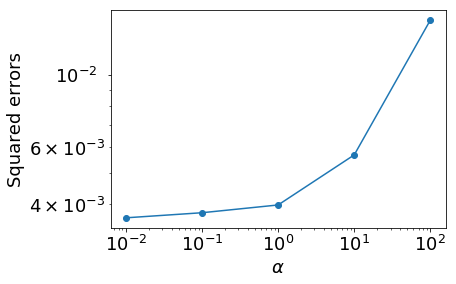

In [45]:
plt.plot(alphas, se_alpha, marker='o')
plt.xlabel(r'$\alpha$')
plt.ylabel('Squared errors')
plt.xscale('log')
plt.yscale('log')
#plt.legend(loc='best')

In [46]:
# OK, let us alpha = 0.1.
# An optimal value can be estimated by the elbow method (refer to the SpM paper by J. Otsuki et al.)
#alpha_best = 0.1
alpha_best = alphas[opt_alpha_idx]
print("best value of alpha", alpha_best)
#alpha_best = 0.1

coeffs = coeffs_alpha[opt_alpha_idx].reshape((3, 2, 2, Nl, Nl))

best value of alpha 1


ValueError: cannot reshape array of size 4332 into shape (3,2,2,30,30)

In [ ]:
Giwn_check = numpy.dot(prj_check.reshape((len(n1n2_check), 3 * 2 * 2 * Nl * Nl)),
                           (coeffs).reshape((3 * 2 * 2 * Nl * Nl)))
Giwn_check_ref = numpy.array([_G2_conn_ph(U, beta, n1n2[0], n1n2[1], boson_freq) for n1n2 in n1n2_check])

diff = numpy.amax(numpy.abs(Giwn_check - Giwn_check_ref))
print(numpy.amax(numpy.abs(Giwn_check - Giwn_check_ref)))
print(diff < 1e-3)

In [ ]:
import matplotlib.pylab as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

N = 100
N_zoom = 30
#x = numpy.linspace(-N, N, 2*N+1)
x = numpy.arange(-N, N+1)
G2_conn_ph = numpy.zeros((2 * N + 1,2 * N + 1), dtype=float)

for i in range(2 * N + 1):
    for j in range(2 * N + 1):
        n = x[i]
        np = x[j]
        G2_conn_ph[i, j] = _G2_conn_ph(U, beta, n, np, boson_freq)

vrange = numpy.amax(numpy.abs(G2_conn_ph))
plt.imshow(G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N - N_zoom: N + N_zoom],
           origin="lower", extent=(-N_zoom, N_zoom, -N_zoom, N_zoom), 
           cmap=cm.bwr, vmin=-vrange/ 2, vmax=vrange / 2
          )
plt.colorbar()
print (vrange)

#plt.legend(loc='best',shadow=True,frameon=False)

In [ ]:
n1n2_check_2d = numpy.array([(x[i], x[j]) for i in range(2 * N + 1) for j in range(2 * N + 1)])
prj_check_2d = numpy.array(phb.projector_to_matsubara_vec(n1n2_check_2d))[:, :, :, :, :, :] * S[None, :]
Giwn_check = numpy.dot(prj_check_2d.reshape((len(n1n2_check_2d), 3 * 2 * 2 * Nl * Nl)),
                           (coeffs).reshape((3 * 2 * 2 * Nl * Nl)))
Giwn_check = Giwn_check.reshape((2 * N + 1, 2 * N + 1))
vrange = numpy.amax(numpy.abs(Giwn_check))
plt.imshow(Giwn_check.real.T[N - N_zoom: N + N_zoom, N - N_zoom: N + N_zoom],
           origin="lower", extent=(-N_zoom, N_zoom, -N_zoom, N_zoom), 
           cmap=cm.bwr, vmin=-vrange/ 2, vmax=vrange / 2
          )
plt.colorbar()

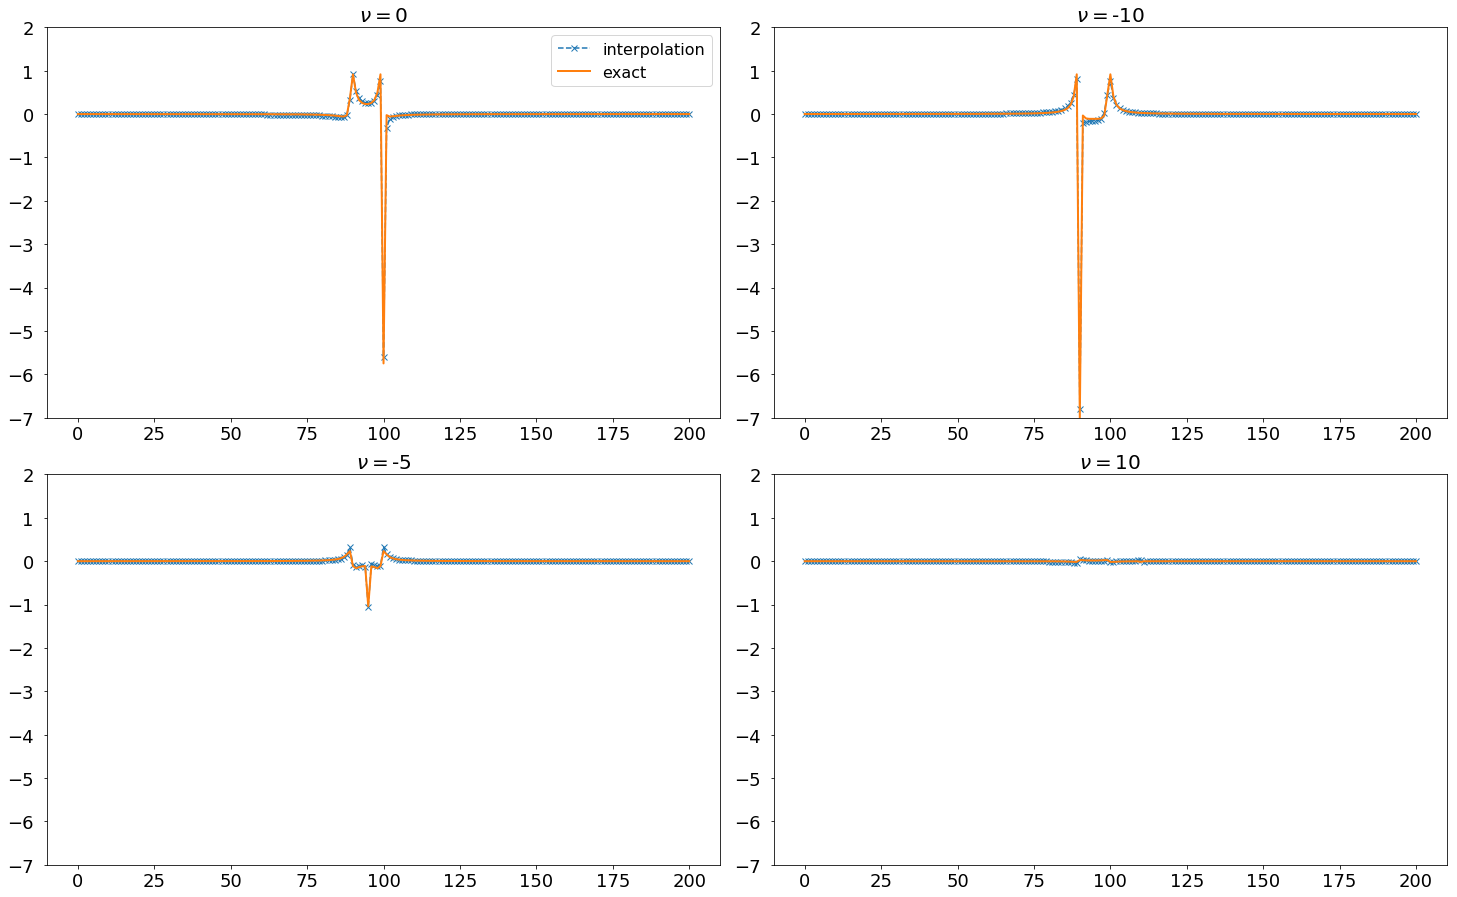

In [14]:
title_size = 20
vert_range = 1.
scale_factor = 100

fig = plt.figure(figsize = (6 * fig_width, 6 * fig_height), frameon=False)

ax = fig.add_subplot(2, 2, 1)
nu_value = 0
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
ax.legend()
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 2)
nu_value = -10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 3)
nu_value = -5
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 4)
nu_value = 10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

plt.tight_layout()
plt.savefig("shapes_comp_wide.pdf")

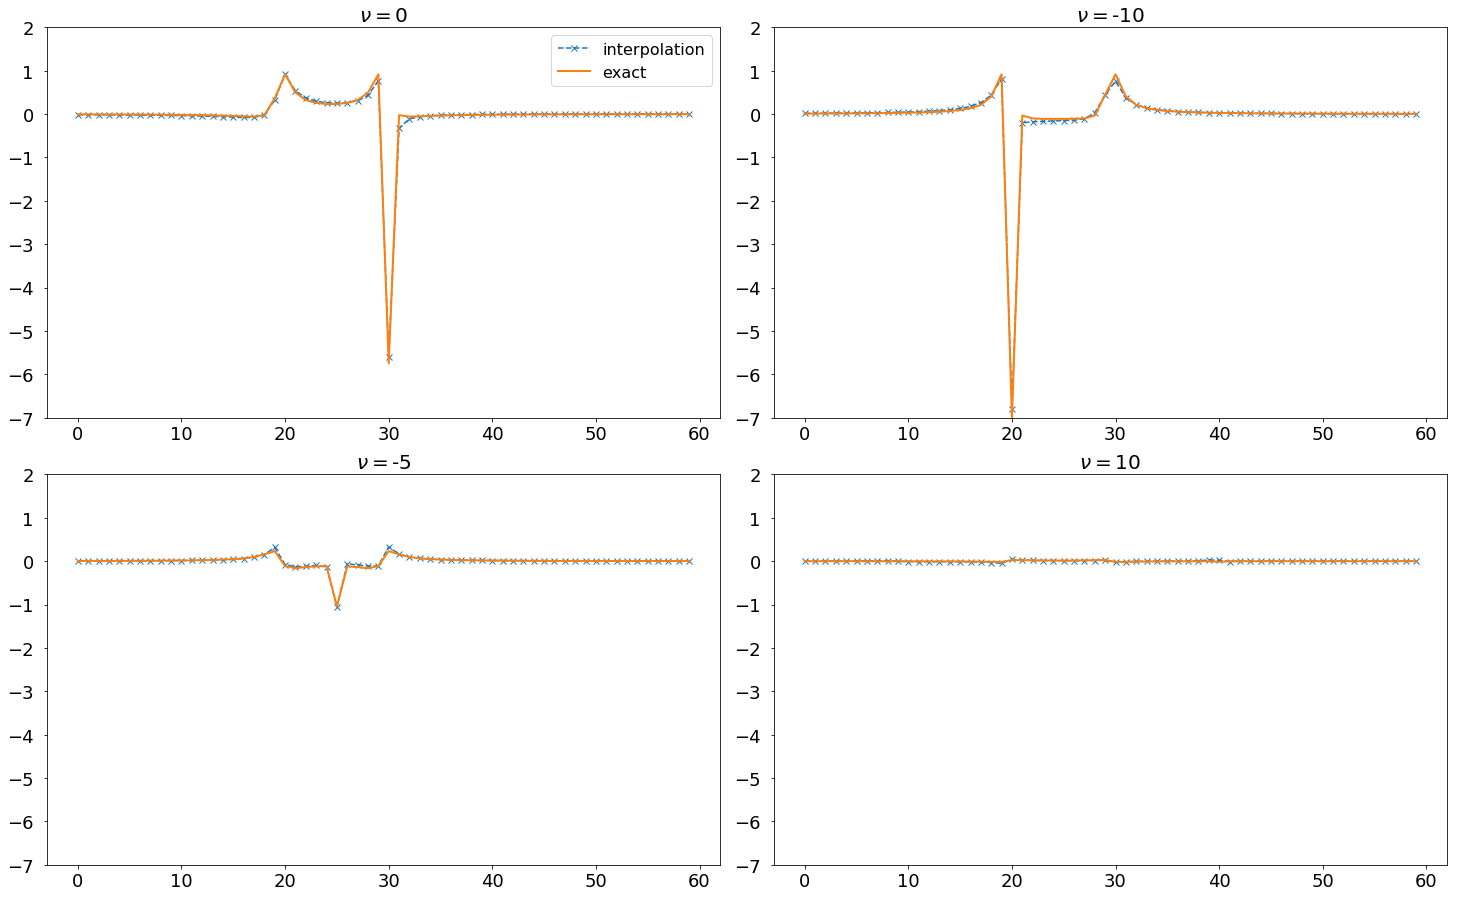

In [15]:
title_size = 20
vert_range = 1.
scale_factor = 100

fig = plt.figure(figsize = (6 * fig_width, 6 * fig_height), frameon=False)

ax = fig.add_subplot(2, 2, 1)
nu_value = 0
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
ax.legend()
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 2)
nu_value = -10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 3)
nu_value = -5
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 4)
nu_value = 10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

plt.tight_layout()
plt.savefig("shapes_comp_zoom.pdf")